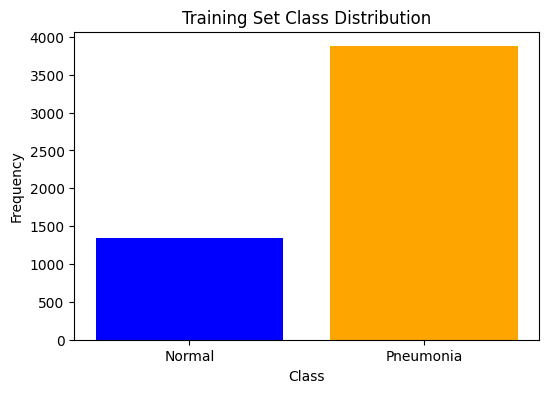

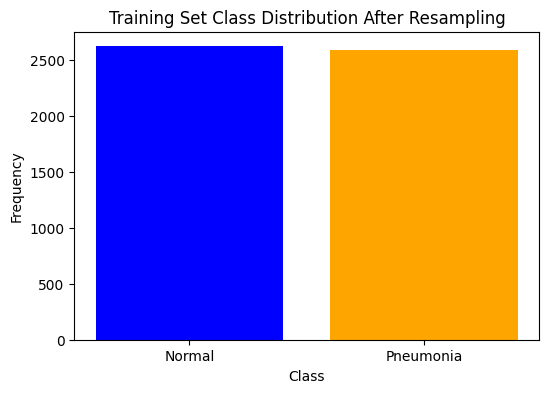

Training ResNet18
Fold 1/3
Epoch 0/0
----------
Batch 0/109 - Loss: 0.7013115286827087
Batch 10/109 - Loss: 0.523690402507782
Batch 20/109 - Loss: 0.19485367834568024
Batch 30/109 - Loss: 0.11919499188661575
Batch 40/109 - Loss: 0.14961692690849304
Batch 80/109 - Loss: 0.0968204215168953
Batch 90/109 - Loss: 0.15603838860988617
Batch 100/109 - Loss: 0.04254496097564697
Train Loss: 0.1959 Acc: 0.9160
Epoch 0/1
----------
Batch 0/109 - Loss: 0.047160372138023376
Batch 10/109 - Loss: 0.0306464321911335
Batch 20/109 - Loss: 0.11503417044878006
Batch 30/109 - Loss: 0.09759993851184845
Batch 40/109 - Loss: 0.1612405925989151
Batch 50/109 - Loss: 0.027563847601413727
Batch 60/109 - Loss: 0.09004111588001251
Batch 70/109 - Loss: 0.045074161142110825
Batch 80/109 - Loss: 0.06129327788949013
Batch 90/109 - Loss: 0.039761804044246674
Batch 100/109 - Loss: 0.14631637930870056
Train Loss: 0.0718 Acc: 0.9773
Epoch 1/1
----------
Batch 0/109 - Loss: 0.0772537887096405
Batch 10/109 - Loss: 0.020176442

In [ ]:
import os
import torch
import yaml
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import KFold
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.models import vgg16,VGG16_Weights, resnet18, ResNet18_Weights

# Setting random seed for reproducibility of data
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)

set_seed()

config = {
    'batch_size': 32,
    'num_epochs': 5,
    'momentum': 0.9,
    'augment': True,
    'save_path': 'best_model.pth'
}

# Write config to YAML file to call the variables
with open('config.yaml', 'w') as file:
    yaml.dump(config, file)

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Loading the dataset
train_dir = 'C:/Users/HP/Documents/projects/NCS/Group_4_NCS/chestray/chest_xray/train'
val_dir = 'C:/Users/HP/Documents/projects/NCS/Group_4_NCS/chestray/chest_xray/val'
test_dir = 'C:/Users/HP/Documents/projects/NCS/Group_4_NCS/chestray/chest_xray/test'

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

batch_size = 32

# Calculating class weights
class_counts = Counter([label for _, label in train_dataset.samples])
num_samples = sum(class_counts.values())
class_weights = {cls: num_samples/class_counts[cls] for cls in class_counts}
weights = [class_weights[label] for _, label in train_dataset.samples]

# Creating sampler
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# Useing the sampler in the DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Plotting class distribution 
def plot_class_distribution(dataset, title='Class Distribution'):
    labels = [label for _, label in dataset.samples]
    counter = Counter(labels)
    plt.figure(figsize=(6, 4))
    plt.bar(counter.keys(), counter.values(), color=['blue', 'orange'])
    plt.xticks([0, 1], ['Normal', 'Pneumonia'])
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

def plot_class_distribution_resampled(dataset, sampler, title='Class Distribution After Resampling'):
    sampled_indices = list(sampler)
    sampled_labels = [dataset.samples[idx][1] for idx in sampled_indices]
    counter = Counter(sampled_labels)
    plt.figure(figsize=(6, 4))
    plt.bar(counter.keys(), counter.values(), color=['blue', 'orange'])
    plt.xticks([0, 1], ['Normal', 'Pneumonia'])
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

# Visualization of class distributions
plot_class_distribution(train_dataset, title='Training Set Class Distribution')
plot_class_distribution_resampled(train_dataset, sampler, title='Training Set Class Distribution After Resampling')

# setting up of model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_folds = 3
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# model training and evaluation functions
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=2):
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        model.train()  

        running_loss = 0.0
        running_corrects = 0

        
        for i, (inputs, labels) in enumerate(train_loader):
            labels = labels.float().to(device)
            inputs = inputs.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs).squeeze()
            preds = (outputs >= 0.5).float()
            loss = criterion(outputs, labels)

            # Backward and optimizer
            loss.backward()
            optimizer.step()

            # loss calculation
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            if i % 10 == 0: 
                print(f'Batch {i}/{len(train_loader)} - Loss: {loss.item()}')

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        train_accuracies.append(epoch_acc.item())
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # validataion of train data
        val_acc = evaluate_model(model, val_loader, validation=True)
        val_accuracies.append(val_acc)

    return model, train_accuracies, val_accuracies

def evaluate_model(model, val_loader, validation=False):
    model.eval()  

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            labels = labels.float().to(device)
            inputs = inputs.to(device)

            outputs = model(inputs).squeeze()
            preds = (outputs >= 0.5).float()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Converting lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # paramater metrics
    accuracy = accuracy_score(y_true, y_pred)
    if not validation:
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        probs = [p for p in outputs.cpu().numpy()]
        auc_roc = roc_auc_score(y_true, probs)
        return accuracy, precision, recall, f1, auc_roc

    return accuracy

def test_model(model, test_loader):
    model.test()  
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            labels = labels.float().to(device)
            inputs = inputs.to(device)

            outputs = model(inputs).squeeze()
            preds = (outputs >= 0.5).float()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Converting lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # parameter metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # probability scores for each class for auc-roc
    probs = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()
            probs.extend(outputs.cpu().numpy())

    auc_roc = roc_auc_score(y_true, probs)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    return accuracy, precision, recall, f1, auc_roc

# ploting confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(title)
    plt.show()

# plotting accuracy over epochs
def plot_accuracies(train_accuracies, val_accuracies, model_name):
    epochs = range(1, len(train_accuracies) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_accuracies, 'b-', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation accuracy')
    plt.title(f'{model_name} Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# initialise the models
models_list = [
    ('ResNet18', resnet18(weights=ResNet18_Weights.IMAGENET1K_V1), nn.Linear(resnet18().fc.in_features, 1)),
    ('VGG16', vgg16(weights=VGG16_Weights.IMAGENET1K_V1), nn.Linear(vgg16().classifier[6].in_features, 1))
]

# model_metrics to store metrics for each model
model_metrics = {}

for model_name, model, final_layer in models_list:
    print(f'Training {model_name}')
    if model_name == 'ResNet18':
        model.fc = nn.Sequential(final_layer, nn.Sigmoid())
    else:
        model.classifier[6] = nn.Sequential(final_layer, nn.Sigmoid())
    model = model.to(device)

    best_accuracy = 0.0
    best_hyperparams = {}
    best_model_state = None

    for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(train_dataset)))):
        print(f'Fold {fold + 1}/{num_folds}')
        train_subsampler = Subset(train_dataset, train_idx)
        val_subsampler = Subset(train_dataset, val_idx)
        train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)

        learning_rates = [0.001, 0.01, 0.1]
        num_epochs_list = [1, 2]

        for lr in learning_rates:
            for num_epochs in num_epochs_list:
                criterion = nn.BCELoss()
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=config['momentum'])

                trained_model, train_accuracies, val_accuracies = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs)

                accuracy = evaluate_model(trained_model, val_loader, validation=True)
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_hyperparams = {'learning_rate': lr, 'num_epochs': num_epochs}
                    best_model_state = trained_model.state_dict()

        print(f'Best hyperparameters for {model_name} fold {fold + 1}: {best_hyperparams}')

        # Train and evaluate the best model on the validation set
        criterion = nn.BCELoss()
        optimizer = optim.SGD(model.parameters(), lr=best_hyperparams['learning_rate'], momentum=config['momentum'])
        model.load_state_dict(best_model_state)
        trained_model, train_accuracies, val_accuracies = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=best_hyperparams['num_epochs'])

        accuracy, precision, recall, f1, auc_roc = evaluate_model(trained_model, val_loader)

        # Store metrics for each model
        if model_name not in model_metrics:
            model_metrics[model_name] = []
        model_metrics[model_name].append({
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'auc_roc': auc_roc
        })

        print(f'{model_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC-ROC: {auc_roc:.4f}')

        # Plotting accuracy over epochs
        plot_accuracies(train_accuracies, val_accuracies, model_name)

        # Evaluating the best model on the test set
        test_accuracy, test_precision, test_recall, test_f1, test_auc_roc = test_model(trained_model, test_loader)
        print(f'Test metrics for {model_name} - Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}, AUC-ROC: {test_auc_roc:.4f}')

        # Plot confusion matrix for the test set
        y_true = []
        y_pred = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                labels = labels.float().to(device)
                inputs = inputs.to(device)
                outputs = trained_model(inputs).squeeze()
                preds = (outputs >= 0.5).float()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        plot_confusion_matrix(y_true, y_pred, classes=['Normal', 'Pneumonia'], title=f'{model_name} Confusion Matrix')

# Plotting comparison metrics
def plot_comparison(metrics_dict, title, ylabel, filename):
    plt.figure(figsize=(10, 6))
    for model_name, metrics in metrics_dict.items():
        plt.plot(range(1, len(metrics) + 1), metrics, marker='o', label=model_name)
    plt.title(title)
    plt.xlabel('Fold')
    plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(filename)
    plt.show()

# Plotting comparison metrics
for metric in ["accuracy", "precision", "recall", "f1_score", "auc_roc"]:
    metric_values = {model_name: [fold[metric] for fold in folds] for model_name, folds in model_metrics.items()}
    plot_comparison(metric_values, f'{metric.capitalize()} Comparison', metric.capitalize(), f'{metric}_comparison.png')
    
# bootstrap aggregating or bagging
def bootstrap_aggregating(models, optimizers, dataset, n_estimators=5, num_epochs=15):
    all_preds = []
    all_labels = []

    for _ in range(n_estimators):
        bootstrap_sample = Subset(dataset, np.random.choice(len(dataset), len(dataset), replace=True))
        loader = DataLoader(bootstrap_sample, batch_size=32, shuffle=True)

        for model, optimizer in zip(models, optimizers):
            model = train_model(model, criterion, optimizer, {'train': loader, 'val': val_loader}, num_epochs)
            accuracy, precision, recall, f1, auc_roc = evaluate_model(model, test_loader)
            all_preds.append(accuracy)
            all_labels.append([label for _, label in test_loader.dataset.samples])

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    final_preds = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=all_preds)

    accuracy = accuracy_score(all_labels[0], final_preds)
    precision = precision_score(all_labels[0], final_preds)
    recall = recall_score(all_labels[0], final_preds)
    f1 = f1_score(all_labels[0], final_preds)
    auc_roc = roc_auc_score(all_labels[0], final_preds)

    return accuracy, precision, recall, f1, auc_roc

vgg_acc, vgg_prec, vgg_recall, vgg_f1, vgg_auc = bootstrap_aggregating([vgg_model], [vgg_optimizer], train_dataset)
resnet_acc, resnet_prec, resnet_recall, resnet_f1, resnet_auc = bootstrap_aggregating([resnet_model], [resnet_optimizer], train_dataset)
print("Detailed Analysis:")
print("1. Accuracy: ")
print(f"   VGG-16: {vgg_acc:.4f}, ResNet-18: {resnet_acc:.4f}")
if resnet_acc > vgg_acc:
    print("   ResNet-18 performed better in terms of accuracy.")
else:
    print("   VGG-16 performed better in terms of accuracy.")

print("\n2. Precision: ")
print(f"   VGG-16: {vgg_prec:.4f}, ResNet-18: {resnet_prec:.4f}")
if resnet_prec > vgg_prec:
    print("   ResNet-18 has higher precision, meaning it has fewer false positives.")
else:
    print("   VGG-16 has higher precision, meaning it has fewer false positives.")

print("\n3. Recall: ")
print(f"   VGG-16: {vgg_recall:.4f}, ResNet-18: {resnet_recall:.4f}")
if resnet_recall > vgg_recall:
    print("   ResNet-18 has higher recall, meaning it has fewer false negatives.")
else:
    print("   VGG-16 has higher recall, meaning it has fewer false negatives.")

print("\n4. F1 Score: ")
print(f"   VGG-16: {vgg_f1:.4f}, ResNet-18: {resnet_f1:.4f}")
if resnet_f1 > vgg_f1:
    print("   ResNet-18 has a better balance between precision and recall.")
else:
    print("   VGG-16 has a better balance between precision and recall.")

print("\n5. AUC-ROC: ")
print(f"   VGG-16: {vgg_auc:.4f}, ResNet-18: {resnet_auc:.4f}")
if resnet_auc > vgg_auc:
    print("   ResNet-18 has a better overall classification performance.")
else:
    print("   VGG-16 has a better overall classification performance.")

    
    # Logging model performance
def log_model_performance(model_name, metrics, model):
    accuracy, precision, recall, f1, auc_roc = metrics
    print(f'{model_name} Metrics:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'AUC-ROC: {auc_roc:.4f}')

    # Log parameters and hardware profile
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{model_name} Number of trainable parameters: {num_params}')
    print(f'Running on device: {device}')

# Log model parameters and hardware profile
def log_model_params_and_device(model, model_name):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'\n{model_name} Parameters and Hardware Profile:')
    print(f'Number of trainable parameters: {num_params}')
    print(f'Running on device: {device}')


# Saving the best model
def save_model(model, path='best_model.pth'):
    torch.save(model.state_dict(), path)

    
# Inference
def inference(model, image_dir, transform):
    model.eval()
    image_files = []
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_files.append(os.path.join(root, file))

    if not image_files:
        print("No image files found in the directory.")
        return None, None

    random_image_file = random.choice(image_files)
    image = Image.open(random_image_file).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        _, preds = torch.max(output, 1)

    return preds.item(), random_image_file

predicted_label, image_path = inference(best_model, os.path.join(data_dir, 'test'), data_transforms['test'])
if predicted_label is not None:
    class_names = ['Normal', 'Pneumonia']
    print(f'Predicted label: {class_names[predicted_label]} for the image: {image_path}')
else:
    print('Inference could not be performed.')

